<a href="https://colab.research.google.com/github/youssefbourais0310/Neural_Networks/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to end multi class breed classification 

this notebook builds an end to end multi class image classifier using tensorflow 2.0 and tensorflow hub .

## 1.problem

identifying the breed of a dog given an image of a dog

## 2.data

the data we are using from kaggle https://www.kaggle.com/c/dog-breed-identification/data?select=test

## 3.evaluation

the evaluation is a file with prediction probabillity for each dog breed of each test image .
https://www.kaggle.com/c/dog-breed-identification/overview

## 4.features

* we have unstructed data 
* there are 120 breed of dogs (120 diffrent classes 
* 10,000 + image in the traning set (the images have labels)
* 10,000 + images in the test set (the images have no labels)

In [14]:
# Unzip the uploaded data into google drive 
#!unzip "drive/MyDrive/dog_vision/dog-breed-identification(1).zip" -d "drive/MyDrive/dog_vision/"

### get our worspace ready 
* import tensorflow 2.x 
* import tensorflow hub
* make sure we are using GPU

In [15]:
#import tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF hub version :", hub.__version__)

#check for GPU avaibility
print("GPU", "avaibility : (YES )" if tf.config.list_physical_devices("GPU") else "not available ")

TF version: 2.7.0
TF hub version : 0.12.0
GPU avaibility : (YES )


## getting our data ready (turning into tensors)
 with all machine learning model our data has to be in numerical format ,so thats what we will be doing 
turning our images into tensors(numerical representation).

* start by accessing our data and cheacking out the labels.

In [16]:
# checkout the lables of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/dog_vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     6d954966a8db66c516beafac3efad4e0  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [17]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


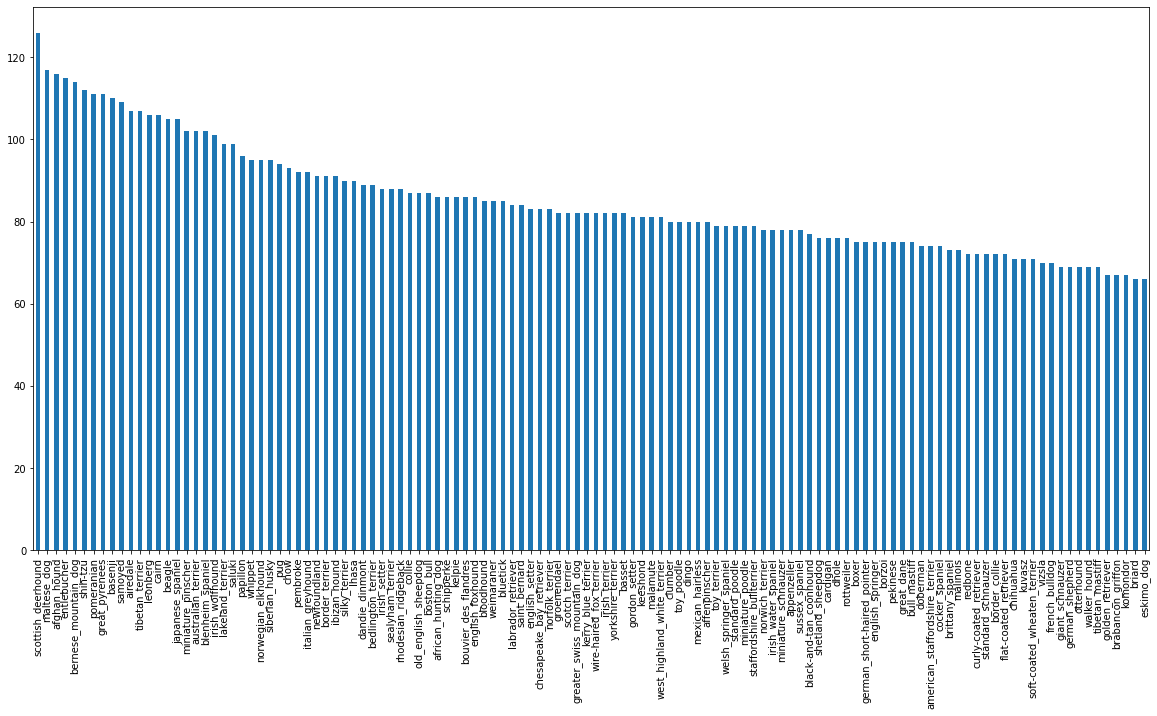

In [18]:
#how many images are there of each breed ?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [19]:
labels_csv["breed"].value_counts().median()

82.0

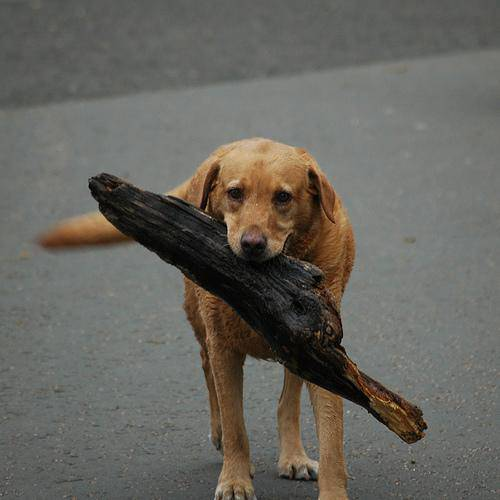

In [20]:
#lets view an image 
from IPython.display import Image 
Image("drive/MyDrive/dog_vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### getting images and their labels
lets get a list of all of our image file pathnames

In [21]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [22]:
#create pathnames from images ID 
filepaths = ["drive/MyDrive/dog_vision/train/" + fpath + ".jpg" for fpath in labels_csv["id"]]

# check the first 10
filepaths[:10]

['drive/MyDrive/dog_vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog_vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog_vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog_vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog_vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog_vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog_vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog_vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog_vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog_vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [23]:
# check whether of filenames matches number of actual image files 
import os 
if len(os.listdir("drive/MyDrive/dog_vision/train/")) == len(filepaths):
  print("filepaths match actual amount of files ! proceed.")
else :
  print ("filepaths do not match actual amount of files , check the target directory.")

filepaths match actual amount of files ! proceed.


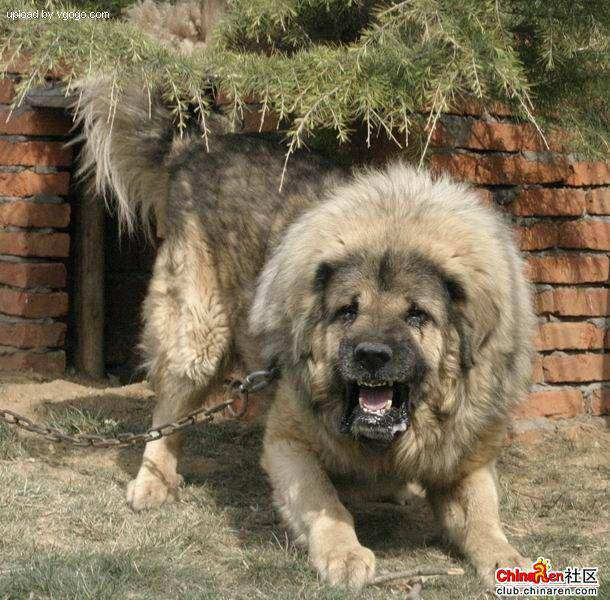

In [24]:
# one more check
Image(filepaths[9000])

In [25]:
labels_csv["breed"][9000]


'tibetan_mastiff'

# lets prepare our labels

In [29]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) #does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [28]:
len(labels)

10222

In [30]:
#see if numbers of labels of number of filenames 
if len(labels) == len(filepaths):
  print("number of labels matches number of filenames")
else : 
  print("number of labels does not match of file names , check data directories!")


number of labels matches number of filenames


In [32]:
# find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [36]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [35]:
# Turn a single label into a booleans
print(labels[0])
labels[0] == unique_breeds 

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [38]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [40]:
len(boolean_labels)

10222

In [39]:
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [42]:
from numpy.ma.extras import unique
#exemple : turning boolean array into integers 
print(labels[0]) #original label
print(np.where(unique_breeds == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [43]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
